<a href="https://colab.research.google.com/github/LiHuaqing-tum/Safe-Flow-Matching/blob/main/without%20phi%20function(maybe%20the%20correct%20vision).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1: Loss = 0.193856
Epoch 2: Loss = 0.062783
Epoch 3: Loss = 0.038890
Epoch 4: Loss = 0.023473
Epoch 5: Loss = 0.015655
Epoch 6: Loss = 0.011005
Epoch 7: Loss = 0.008268
Epoch 8: Loss = 0.006434
Epoch 9: Loss = 0.005216
Epoch 10: Loss = 0.004393
Epoch 11: Loss = 0.003726
Epoch 12: Loss = 0.003258
Epoch 13: Loss = 0.002862
Epoch 14: Loss = 0.002698
Epoch 15: Loss = 0.002536
Epoch 16: Loss = 0.002422
Epoch 17: Loss = 0.002282
Epoch 18: Loss = 0.002210
Epoch 19: Loss = 0.002141
Epoch 20: Loss = 0.002095
Epoch 21: Loss = 0.002039
Epoch 22: Loss = 0.002012
Epoch 23: Loss = 0.001938
Epoch 24: Loss = 0.001960
Epoch 25: Loss = 0.001932
Epoch 26: Loss = 0.001924
Epoch 27: Loss = 0.001847
Epoch 28: Loss = 0.001807
Epoch 29: Loss = 0.001798
Epoch 30: Loss = 0.001790


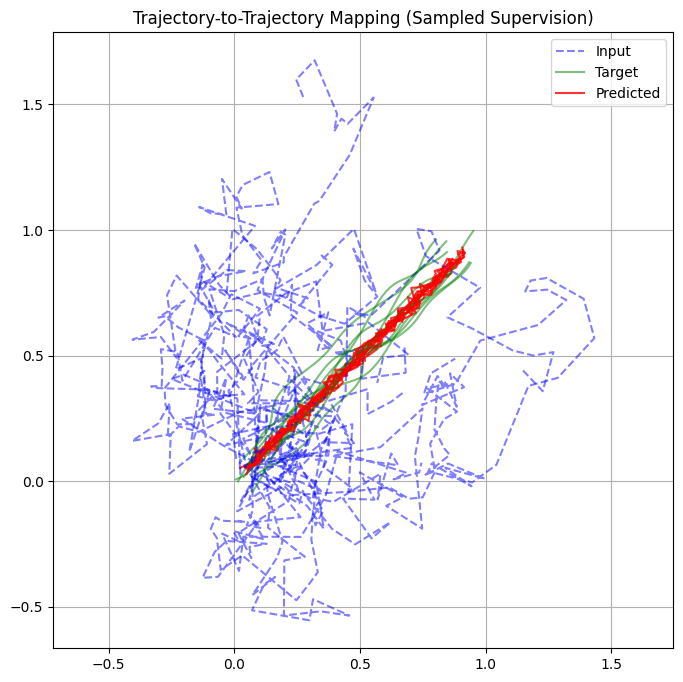

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


def generate_trajectory_pairs(n_samples=500, steps=50):
    input_trajs = []
    target_trajs = []
    for _ in range(n_samples):
        traj = np.zeros((steps, 2))
        traj[0] = np.random.rand(2) * 0.1
        for t in range(1, steps):
            traj[t] = traj[t - 1] + 0.1 * np.random.randn(2)
        input_trajs.append(traj)

        start = np.random.rand(2) * 0.1
        end = np.array([0.9, 0.9]) + 0.05 * np.random.randn(2)
        t_lin = np.linspace(0, 1, steps).reshape(-1, 1)
        base = start + (end - start) * t_lin
        curve = (
            0.05 * np.sin(2 * np.pi * t_lin + np.random.rand() * 2 * np.pi) +
            0.02 * np.sin(6 * np.pi * t_lin + np.random.rand() * 2 * np.pi)
        )
        if np.random.rand() > 0.5:
            base[:, 0] += curve[:, 0]
        else:
            base[:, 1] += curve[:, 0]
        target_trajs.append(base)

    return np.array(input_trajs), np.array(target_trajs)


class TrajectoryPairDataset(Dataset):
    def __init__(self, input_trajs, target_trajs):
        self.input_trajs = torch.tensor(input_trajs, dtype=torch.float32)
        self.target_trajs = torch.tensor(target_trajs, dtype=torch.float32)

    def __len__(self):
        return len(self.input_trajs)

    def __getitem__(self, idx):
        return self.input_trajs[idx], self.target_trajs[idx]

class TrajectoryMapper(nn.Module):
    def __init__(self, steps=50, dim=2, hidden=256):
        super().__init__()
        self.steps = steps
        self.dim = dim
        self.net = nn.Sequential(
            nn.Linear(steps * dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, steps * dim)
        )

    def forward(self, x):
        B = x.shape[0]
        x_flat = x.view(B, -1)
        y_flat = self.net(x_flat)
        return y_flat.view(B, self.steps, self.dim)

def train(model, dataset, n_epochs=30, batch_size=64, lr=1e-3):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = F.mse_loss(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(loader):.6f}")


def visualize_predictions(model, x_data, y_data, num_samples=10):
    model.eval()
    with torch.no_grad():
        device = next(model.parameters()).device
        x = torch.tensor(x_data[:num_samples], dtype=torch.float32).to(device)
        y_pred = model(x).cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(num_samples):
        plt.plot(x_data[i, :, 0], x_data[i, :, 1], 'b--', alpha=0.5, label='Input' if i == 0 else "")
        plt.plot(y_data[i, :, 0], y_data[i, :, 1], 'g-', alpha=0.5, label='Target' if i == 0 else "")
        plt.plot(y_pred[i, :, 0], y_pred[i, :, 1], 'r-', alpha=0.8, label='Predicted' if i == 0 else "")
    plt.title("Trajectory-to-Trajectory Mapping (Sampled Supervision)")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.show()


steps = 50
input_trajs, target_trajs = generate_trajectory_pairs(n_samples=500, steps=steps)
dataset = TrajectoryPairDataset(input_trajs, target_trajs)
model = TrajectoryMapper(steps=steps)
train(model, dataset, n_epochs=30)
visualize_predictions(model, input_trajs, target_trajs)



Step 0, Loss = 11.867138
Step 100, Loss = 0.029665
Step 200, Loss = 0.025666
Step 300, Loss = 0.028905
Step 400, Loss = 0.027818
Step 500, Loss = 0.027855
Step 600, Loss = 0.026467
Step 700, Loss = 0.026849
Step 800, Loss = 0.028062
Step 900, Loss = 0.026097


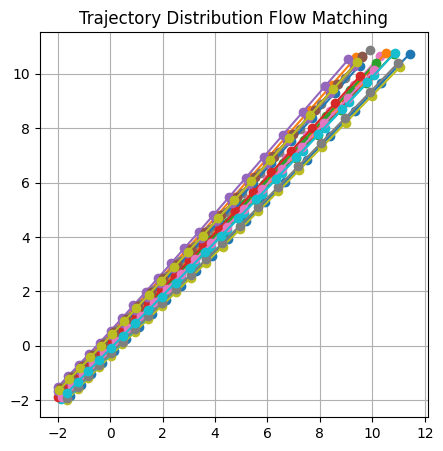